In [52]:
#defined functions

import sympy as sym
# calcualtes the Shannon entropy for a given list of (symbolic) probabilities
def entropy(prob_list):
    H = 0
    for p in prob_list:
        H -= p*sym.log(p, 2)

    return(H)


import numpy as np
import scipy as sp
# calculates the plug in entropy estimate for the elements of a given input sequence
def plugin_entropy(s):
    
    # calculate frequency of each unique sample value in order of appearance
    ucount = np.unique(s, return_counts = True)[1]
    # calculate entropy
    H = sp.stats.entropy(ucount, base = 2)

    return(H)


import sympy as sym
# calculates the stationary distribution of a Markov Process using its transition matrix P
def MP_stat_dist(P): 

    # make symbolic if not already the case
    P = sym.Matrix(P)
    # take eigenvector with eigenvalue 1
    eigenvectors = P.T.eigenvects()
    eigenvector = [eig for eig in eigenvectors if eig[0]==1]
    stationary_dist = eigenvector[0][2][0]
    # normalize to probability vector
    stationary_dist = (stationary_dist/sum(stationary_dist)).T 

    return(sym.simplify(stationary_dist))


import sympy as sym
import numpy as np
# calculates the entropy rate of a stationary Markov Process (Cover&Thomas)
def MP_entropy_rate(stat, P, mapping):
    
    # make inputs symbolic if not already
    stat_sym = sym.Matrix(stat)
    P_sym = sym.Matrix(P)

    # map stat and P with given mapping
    stat_mapped = stat_sym #sym.Matrix(np.zeros((stat_sym.shape[0], stat_sym.shape[1])))
    P_mapped = sym.Matrix(np.zeros((P_sym.shape[0], P_sym.shape[1])))
    for i in range(P_sym.shape[0]):
        #stat_mapped[mapping[i]] += stat_sym[i]
        for j in range(P_sym.shape[1]):
            P_mapped[i, mapping[j]] += P_sym[i, j]

    # calculate entropy rate
    P_log = sym.matrix_multiply_elementwise(P_mapped, P_mapped.applyfunc(lambda x: sym.log(x, 2)))
    h = sym.simplify(-np.sum(P_log.T * stat_mapped.T))

    return(h.evalf())


import sympy as sym
import numpy as np
import itertools
# calculates block entropy of length block_length for MP with transition matrix P
def MP_block_entropy(P, block_length, init_prob, mapping):

    # get possible combinations of length = block_length
    P_size = np.shape(P)[0]
    blocks = list(itertools.product(range(P_size), repeat = block_length))

    # calculate probability for each possible block
    prob_blocks = list()
    for block in blocks:
        prob_block = 1
        for l in range(block_length):
            if l == 0:
                prob_block *= init_prob[block[l]]
            else:
                prob_block *= P[block[l-1], block[l]]
        prob_blocks.append(prob_block)

    # remove blocks with invalid probabilities (p=0)
    if 0 in prob_blocks: 
        blocks = [blocks[i] for i in range(len(blocks)) if prob_blocks[i] != 0]
        prob_blocks = list(filter(lambda p_b: p_b != 0, prob_blocks))
    # renormalize to have sum(prob_blocks) = 1
    prob_blocks = [p_b / np.sum(prob_blocks) for p_b in prob_blocks]

    # re-map blocks to other symbols according to the given mapping
    blocks_mapped = [tuple(mapping[symbol] for symbol in block) for block in blocks]
    # reduce the list, combining identical blocks and their probabilities
    blocks_reduced = {}
    for sequence, prob in zip(blocks_mapped, prob_blocks):
        blocks_reduced[sequence] = blocks_reduced.get(sequence, 0) + prob

    # calculate entropy
    H = entropy(list(blocks_reduced.values()))
        
    return(H)

### An information-theoretical approach to internal models in a Partially Observable Markov Decision Process

##### Rat in a box

<div style="text-align: center;"> <img src="mdp_fig.png" height=50"> </div>  
MDP  

$p_x = \text{probability of light turning on},\ \pi_{a_i},\pi_{a_i} = \text{agent policy to act or wait}$

The rat can act (push the button) or wait, with reward for acting in $S_2$ 

#### How can an observer see that there is a more complex process going on?

Measures from information theory, (Crutchfield & Feldman, 2001):  

Shannon entropy for blocks of some length $L$, where each block is a sequence of $L$ consecutive observations of $s_i \epsilon S$:
$$ H(s^L) = -\sum_{s_i^L \epsilon S^L} p(s_i^L) \log_2p(s_i^L) $$  

Example for MDP, $L=1,2$:  

$H(s^1) = -[p(S_0)\log_2(S_0)+p(S_1)\log_2(S_1)+p(S_2)\log_2(S_2)]$  
 
$H(s^2) = -[p(S_0S_0)\log_2(S_0S_0)+p(S_0S_1)\log_2(S_0S_1)+p(S_1S_0) \log_2(S_1S_0)+p(S_1S_2)\log_2(S_1S_2)]$

##### How does this block entropy change for longer and longer sequences? $\to$ entropy rate $h_\mu$  

$$ h_\mu = \lim_{L \to \infty} \frac{H(s^L)}{L} $$

##### How does the block entropy $H(s^L)$ converge to the entropy rate $h_\mu$? $\to$ excess entropy $E$

$$ E = \lim_{L \to \infty} [H(s^L) - h_{\mu}L] $$

<div style="text-align: center;"> <img src="crutchfield_figs.png" height="50"> </div>

Figures from (Crutchfield & Feldman, 2001). Left showing the block entropy $H(s^L)$, here $H(L)$, behaviour for increasing $L$, Right showing concept of synchronization.

##### When is an agent able to estimate the entropy rate $h_\mu$ correctly? $\to$ synchronization

The agent is said to be synchronized, if block entropy scales with entropy rate, so $E + h_{\mu}L - H(s^L) = 0$  
The total uncertainty encountered until this synchronization is achieved is called transient information $T$

$$ T = \sum_{L=0}^{\infty} E + h_{\mu}L - H(s^L) $$

##### So, what about the rat problem?

(Crutchfield & Feldman, 2001) mainly looks at periodic sequences, what about a Markov Process?

Additional definitions for MPs (Cover & Thomas, 1999):  

Given a MP with state-transition matrix $P$, if the MP is stationary (transition probabilities do not change), then:
$\mu$ is the stationary distribution vector with: 
$$ \mu = \mu P $$ 
$\to$ solve as a special eigenvector problem.

$\implies$ the MP has an entropy rate given by:
$$ h_\mu = \sum_{i,j} \mu_i P_{ij} \log_2 P_{ij} $$

#### For the rat in the box:

How can we model this synchronization for an observer of the system?  
Assumption: we start to observe the system in stationarity.

##### First approach, create observation Markov processes

<div style="text-align: center;"> <img src="mdp_mp1_mp2_fig.png" height="50"> </div>  

MDP

In [53]:
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mdp = sym.Matrix([[1-x, x, 0], [a1, 0, 1-a1], [1, 0, 0]])
stat_mdp = MP_stat_dist(P_mdp)
stat_mdp_l = sym.lambdify([x, a1], stat_mdp)  # lambdify for later evaluation
stat_mdp

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 1)/(\pi_{a1}*p_X - 2*p_X - 1)]])

MP1

In [54]:
import sympy as sym

x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")

P_mp1 = sym.Matrix([[1-x, x], [1/(2-a1), (1-a1)/(2-a1)]])
stat_mp1 = MP_stat_dist(P_mp1)
stat_mp1_l = sym.lambdify([x, a1], stat_mp1)  # lambdify for later evaluation
stat_mp1

Matrix([[1/(-\pi_{a1}*p_X + 2*p_X + 1), p_X*(\pi_{a1} - 2)/(\pi_{a1}*p_X - 2*p_X - 1)]])

MP2

In [55]:
import sympy as sym

x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")

pa = stat_mdp[0]*a0 + stat_mdp[1]*a1 + stat_mdp[2]*a2
P_mp2 = sym.Matrix([[pa, 1-pa], [pa, 1-pa]])

# P_mp2 is already stationary
stat_mp2 = sym.Matrix([[sym.simplify(pa), sym.simplify(1-pa)]])
# lambdify for later evaluation
stat_mp2_l = sym.lambdify([x, a0, a1, a2], stat_mp2)
stat_mp2

Matrix([[(\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1))/(-\pi_{a1}*p_X + 2*p_X + 1), (-\pi_{a0} - 2*\pi_{a1}*p_X + \pi_{a2}*p_X*(\pi_{a1} - 1) + 2*p_X + 1)/(-\pi_{a1}*p_X + 2*p_X + 1)]])

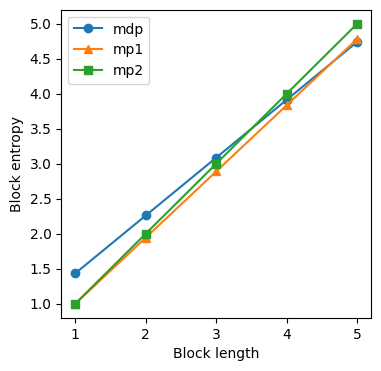

In [56]:
import numpy as np
import sympy as sym
import scipy as sp
import itertools
import matplotlib.pyplot as plt

vects = [stat_mdp, stat_mp1, stat_mp2]
labels = ["mdp", "mp1", "mp2"]
markers = ["o", "^", "s"]
Ps = [P_mdp, P_mp1, P_mp2]

plt.figure(figsize =(4,4))
for n, vect in enumerate(vects):
    P_s = Ps[n]
    vars = [x, a0, a1, a2]
    vals = [0.60, 0.5, 0.5, 0.5]

    vect = vect.subs({vars[i]: vals[i] for i in range(len(vars))})
    P_s = P_s.subs({vars[i]: vals[i] for i in range(len(vars))})

    inits = [vect, vect, vect]  # init = stationary

    lengths = range(1, 6)
    mapping = {i: i for i in range(len(vect))}

    ent_rate = MP_entropy_rate(vect, P_s, mapping)
    block_ents = [MP_block_entropy(P_s, l, inits[n], mapping) for l in lengths]

    plt.plot(lengths, block_ents, marker=markers[n], label=labels[n])

plt.xlabel("Block length")
plt.ylabel("Block entropy")
plt.legend()
plt.show()

##### Second approach, treat it as a Hidden Markov Process

<div style="text-align: center;"> 
<img src="mdp_obs_fig.png" height="50"> 
</div> 

mdp
entropy rate
analytical | discrete estimate
0.826816102344562 | 0.573105250181697/log(2)
[0.993268210149961/log(2), 1.56637346033166/log(2), 2.13947871051335/log(2), 2.71258396069505/log(2), 3.28568921087675/log(2)]
obs(mdp,L)
entropy rate
analytical | discrete estimate
0.826816102344562 | 0.573105250181697/log(2)
[0.691761498852418/log(2), 1.34748487699694/log(2), 1.92059012717863/log(2), 2.49369537736033/log(2), 3.06680062754203/log(2)]


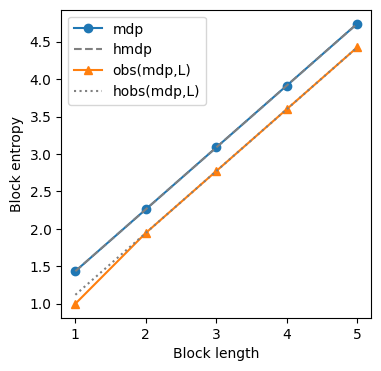

In [57]:
import numpy as np
import sympy as sym
import scipy as sp
import itertools
import matplotlib.pyplot as plt

vects = [stat_mdp, stat_mdp]
labels = ["mdp", "obs(mdp,L)"]
markers = ["o", "^"]
Ps = [P_mdp, P_mdp]
mapping = [{0: 0, 1: 1, 2: 2}, {0: 0, 1: 1, 2: 1}]
style = ["--", ":"]

plt.figure(figsize =(4,4))

for n, vect in enumerate(vects):
    P_s = Ps[n]
    vars = [x, a0, a1, a2]
    vals = [0.60, 0.5, 0.5, 0.5]

    ent_rate = MP_entropy_rate(vect, P_s, mapping[n])
    #print(sym.simplify(ent_rate))

    vect = vect.subs({vars[i]: vals[i] for i in range(len(vars))})
    P_s = P_s.subs({vars[i]: vals[i] for i in range(len(vars))})

    inits = [vect, vect, vect]  # init = stationary

    lengths = range(1, 6)

    ent_rate = MP_entropy_rate(vect, P_s, mapping[n])
    block_ents = [MP_block_entropy(
        P_s, l, inits[n], mapping[n]) for l in lengths]

    print(labels[n])
    print("entropy rate")
    print("analytical | discrete estimate")
    print(ent_rate, "|", block_ents[-1] - block_ents[-2])
    print(block_ents)

    plt.plot(lengths, block_ents, marker=markers[n], label=labels[n])
    # plot excess entropy estimate
    plt.plot(np.arange(1, 6), ent_rate*np.arange(1, 6) +
             (block_ents[-1]-ent_rate*5), color="grey", ls=style[n], label=str("h"+labels[n]))

plt.xlabel("Block length")
plt.ylabel("Block entropy")
plt.legend()
plt.show()

mdp
entropy rate
analytical | discrete estimate
0.742438185145091 | 0.514618934773364/log(2)
[1.03519929987627/log(2), 1.54981823464963/log(2), 2.064437169423/log(2), 2.57905610419636/log(2), 3.09367503896972/log(2)]
obs(mdp,A)
entropy rate
analytical | discrete estimate
0.940057780799657 | 0.685278465029803/log(2)
[0.692511814145032/log(2), 1.38144476798026/log(2), 2.06907890375316/log(2), 2.75464303978077/log(2), 3.43992150481057/log(2)]


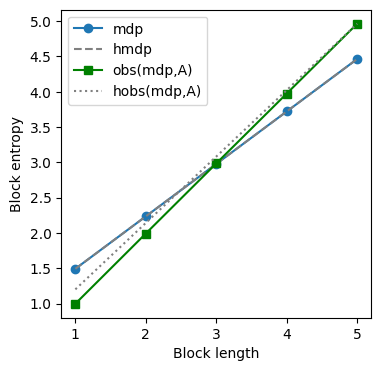

In [58]:
                        #AS0  WS0  AS1  WS1  WS2 (AS2 not possible, would be zero column/row)
P_mdp_full = sym.Matrix([[a0*(1-x), (1-a0)*(1-x), a0*x, (1-a0)*x, 0], # AS0
                         [a0*(1-x), (1-a0)*(1-x), a0*x, (1-a0)*x, 0], # WS0
                         [a1*1, 0, 0, 0, (1-a1)*1], # AS1
                         [a1*1, 0, 0, 0, (1-a1)*1], # WS1
                         [a2*1, (1-a2)*1, 0, 0, 0]])# WS2 

stat_mdp_full = MP_stat_dist(P_mdp_full)
vects = [stat_mdp_full, stat_mdp_full, stat_mdp_full, stat_mdp_full]
labels = ["mdp_full", "mdp", "obs(mdp,L)", "obs(mdp,A)"]
markers = ["p", "o", "^", "s"]
Ps = [P_mdp_full, P_mdp_full, P_mdp_full, P_mdp_full]
mapping = [{0:0, 1:1, 2:2, 3:3, 4:4}, {0:0, 1:0, 2:1, 3:1, 4:2}, 
           {0:0, 1:0, 2:1, 3:1, 4:1}, {0:1, 1:0, 2:1, 3:0, 4:0}]
cols = ["C0", "C0", "green", "green"]

plt.figure(figsize =(4,4))

for n in [1, 3]:
    vect = vects[n]
    P_s = Ps[n]
    vars = [x, a0, a1, a2]
    vals = [0.60, 0.5, 0.3, 0.7]
    l_ls = ["--", "--", "-.", ":"]

    vect = vect.subs({vars[i]: vals[i] for i in range(len(vars))})
    P_s = P_s.subs({vars[i]: vals[i] for i in range(len(vars))})

    init = vect  # init = stationary

    lengths = range(1, 6)

    ent_rate = MP_entropy_rate(vect, P_s, mapping[n])
    block_ents = [MP_block_entropy(P_s, l, init, mapping[n]) for l in lengths]

    print(labels[n])
    print("entropy rate")
    print("analytical | discrete estimate")
    print(ent_rate, "|", block_ents[-1] - block_ents[-2])
    print(block_ents)

    plt.plot(lengths, block_ents, color = cols[n], marker=markers[n], label=labels[n])
    # plot excess entropy estimate
    ent_rate_est = block_ents[-1] - block_ents[-2]
    plt.plot(np.arange(1, 6), ent_rate*np.arange(1, 6) +
                (block_ents[-1]-ent_rate*5), color="grey", ls=l_ls[n], label=str("h"+labels[n]))

plt.xlabel("Block length")
plt.ylabel("Block entropy")
plt.legend()
plt.show()